In [10]:
import numpy as np
import numpy.ma as ma

from mpl_toolkits import mplot3d
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl
from numpy import arange,array,ones,linalg
from scipy.optimize import minimize
from scipy import ndimage
from scipy import stats

from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
from astropy.utils.data import get_pkg_data_filename
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.nddata import bitmask
from astropy.nddata.bitmask import BitFlagNameMap
import math
from tqdm import tqdm

import copy

from scipy.ndimage import gaussian_filter1d

from sympy.interactive import printing
printing.init_printing(use_latex = True)

In [11]:
import os
current_directory = os.getcwd()
print(current_directory)

/global/u1/j/jlargett/DESI_SGA/Morphology


In [12]:
#SGA_Param_Data = Table.read('SGA_Asym_Data.fits')
SGA_Param_Data = Table.read('SGA_M20_Data1.fits')
SGA_Param_Data

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,COLOR G-Z,COLOR G-R,COLOR R-Z,R50_R,m(r50)_G,m(r50)_Z,m(r50)_R,GRADIENT_G-Z,GRADIENT_G-R,GRADIENT_R-Z,C_INDEX_G_r50_r90,C_INDEX_R_r50_r90,C_INDEX_Z_r50_r90,r90_R,r50_G,r90_G,r50_Z,r90_Z,GINI_G,GINI_R,GINI_Z,Asymmetry_G,Asymmetry_R,Asymmetry_Z,M20_G,M20_R,M20_Z
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.004

In [19]:
# Path to a random image in NERSC
f1 = math.trunc(SGA_Param_Data['RA'][1])
f2 = math.trunc((1000*SGA_Param_Data['RA'][1]))
f3 = math.trunc((100000*SGA_Param_Data['RA'][1]))
f4 = 'm' if SGA_Param_Data['DEC'][1] < 0 else 'p'
f5 = abs(math.trunc((100000*SGA_Param_Data['DEC'][1])))
#path = '/pscratch/sd/b/barnerg/SGA2024/cutouts/{:03d}/{:06d}/{:08d}{}{:07d}.fits'.format(f1,f2,f3,f4,f5)
#path = '/pscratch/sd/b/barnerg/SGA2024/cutouts/222/222749/22274970p1386192.fits'
#path = '/pscratch/sd/b/barnerg/SGA2024/cutouts/188/188533/18853364p4559562.fits'
#path = '/pscratch/sd/b/barnerg/SGA2024/cutouts/182/182088/18208882p2560226.fits'
path = '/pscratch/sd/b/barnerg/SGA2024/cutouts/193/193707/19370744p5888232.fits'
#path = '/pscratch/sd/b/barnerg/SGA2024/cutouts/244/244163/24416352p4034080.fits'
fits_file = fits.open(path)
image = fits_file[0].data
bit_mask = fits_file[1].data

In [20]:
print(f"Image Shape: {image.shape}")
print(f"Bitmask Shape: {bit_mask.shape}")

Image Shape: (3, 445, 445)
Bitmask Shape: (445, 445)


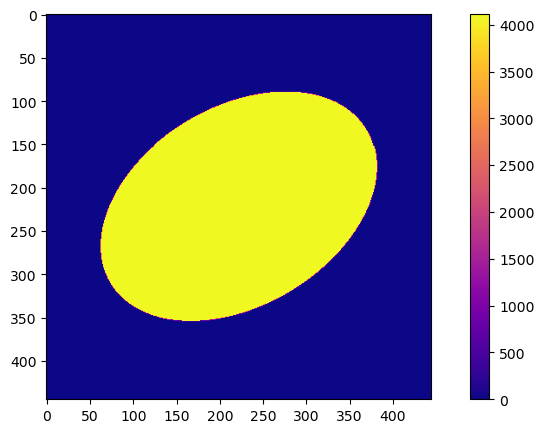

In [8]:
# Showing image 
plt.rcParams["figure.figsize"] = (10, 5)
plt.imshow(bit_mask, cmap='plasma')
plt.colorbar()

In [9]:
# Reshape the data
if image.shape[0] == 3:
    image_data = np.transpose(image, (1, 2, 0))
print(f"Image Shape: {image_data.shape}")

Image Shape: (445, 445, 3)


In [8]:
fits_file.close()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


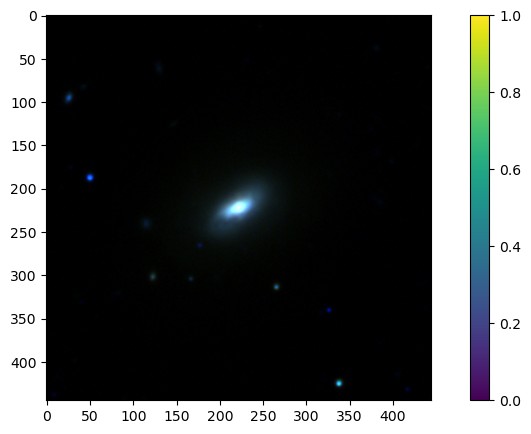

In [9]:
# Showing normal image 
plt.rcParams["figure.figsize"] = (10, 5)
plt.imshow(image_data)
plt.colorbar()

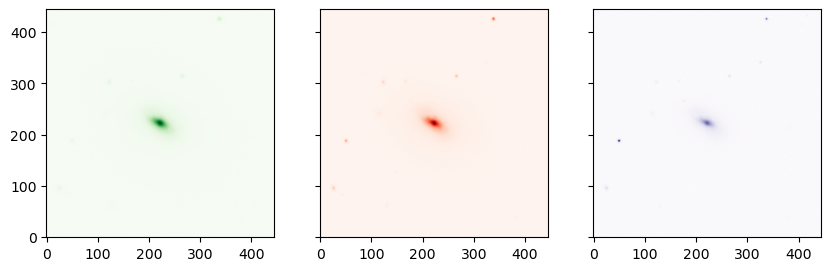

In [10]:
mg_image = ma.array(image_data[:,:,0])
mr_image = ma.array(image_data[:,:,1])
mz_image = ma.array(image_data[:,:,2])

plt.figure()
ax1=plt.subplot(131)
plt.imshow(mg_image, origin='lower', cmap='Greens')
plt.subplot(132, sharey=ax1)
plt.imshow(mr_image, origin='lower', cmap='Reds')
plt.tick_params('y', labelleft=False)
plt.subplot(133, sharey=ax1)
plt.imshow(mz_image, origin='lower', cmap='Purples')
plt.tick_params('y', labelleft=False);

In [11]:
# Bits in the dict
MASKBITS = dict(
    NPRIMARY   = 0x1,   # not PRIMARY
    BRIGHT     = 0x2,
    SATUR_G    = 0x4,
    SATUR_R    = 0x8,
    SATUR_Z    = 0x10,
    ALLMASK_G  = 0x20,
    ALLMASK_R  = 0x40,
    ALLMASK_Z  = 0x80,
    WISEM1     = 0x100, # WISE masked
    WISEM2     = 0x200,
    BAILOUT    = 0x400, # bailed out of processing
    MEDIUM     = 0x800, # medium-bright star
    GALAXY     = 0x1000, # SGA large galaxy
    CLUSTER    = 0x2000, # Cluster catalog source
    SATUR_I    = 0x4000,
    ALLMASK_I  = 0x8000,
    SUB_BLOB   = 0x10000,
)

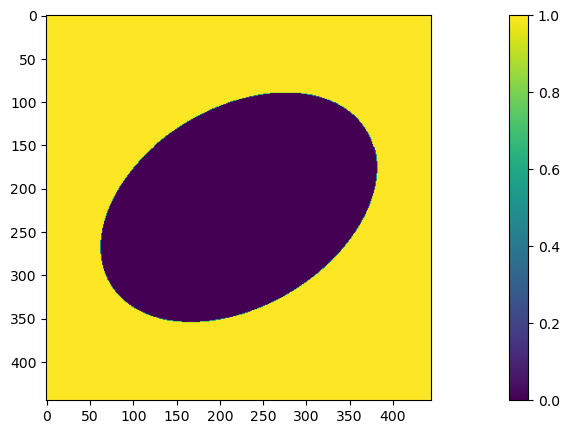

In [12]:
# Generate bitmask to apply to image
condition = bit_mask & MASKBITS['GALAXY'] != 0
mask_ = condition.astype(int)

# Generate bitmask to apply to image
condition2 = mask_ & (MASKBITS['BRIGHT'] | MASKBITS['SATUR_G'] | MASKBITS['SATUR_R'] | MASKBITS['SATUR_Z'] | MASKBITS['WISEM1'] | MASKBITS['WISEM2']) != 0
mask_2 = mask_ & ~condition2

# Showing masked image
plt.rcParams["figure.figsize"] = (20, 5)
plt.imshow(~(mask_2.astype(bool)))
plt.colorbar();

Mask Shape: (445, 445, 3)
Mask_2 Shape: (445, 445)
Masked Image Shape: (445, 445, 3)


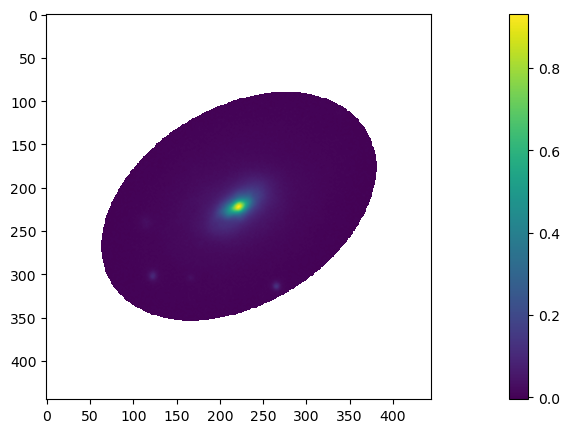

In [13]:
mask = np.dstack([mask_2.astype(bool), mask_2.astype(bool), mask_2.astype(bool)])
print(f"Mask Shape: {mask.shape}")
print(f"Mask_2 Shape: {mask_2.shape}")

mimage_data = ma.array(image_data, mask=~mask)
print(f"Masked Image Shape: {mimage_data.shape}")

plt.rcParams["figure.figsize"] = (20, 5)
plt.imshow(mimage_data[:,:,0])
plt.colorbar();

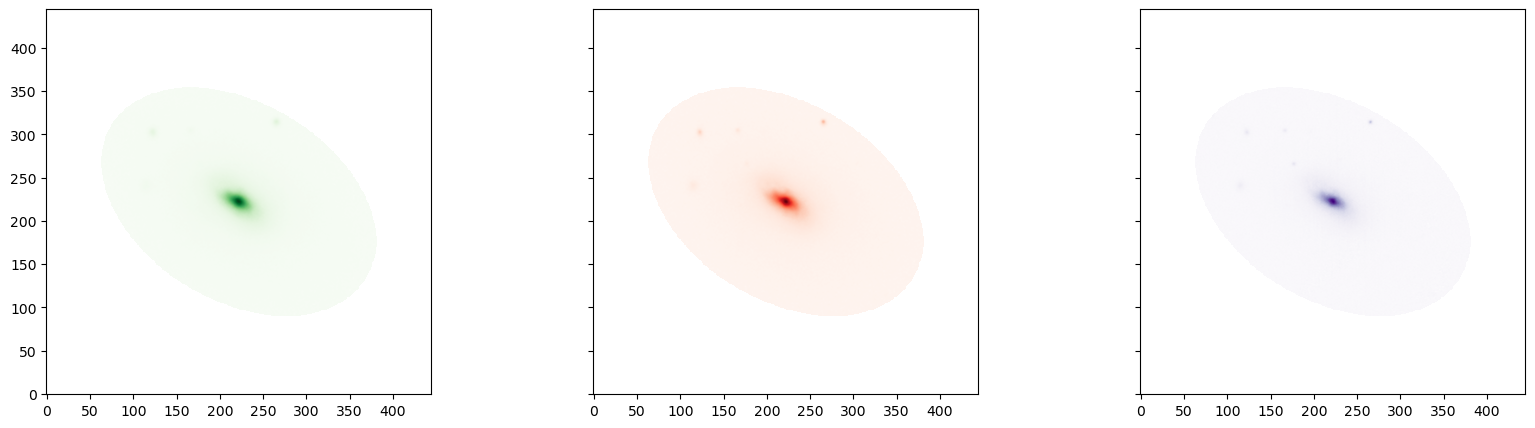

In [14]:
# color images
mmg_image = ma.array(image_data[:,:,0], mask=~mask_2.astype(bool))
mmr_image = ma.array(image_data[:,:,1], mask=~mask_2.astype(bool))
mmz_image = ma.array(image_data[:,:,2], mask=~mask_2.astype(bool))

# Use the masks from the original images
mask_g = mmg_image.mask
mask_r = mmr_image.mask
mask_z = mmz_image.mask

plt.figure()
ax1=plt.subplot(131)
plt.imshow(mmg_image, origin='lower', cmap='Greens')
plt.subplot(132, sharey=ax1)
plt.imshow(mmr_image, origin='lower', cmap='Reds')
plt.tick_params('y', labelleft=False)
plt.subplot(133, sharey=ax1)
plt.imshow(mmz_image, origin='lower', cmap='Purples')
plt.tick_params('y', labelleft=False);

In [15]:
# messing around with the g band

# extract the image shape and coordinates for g, r, and z.
rowsg, colsg = mmg_image.shape
yg, xg = np.mgrid[0:rowsg, 0:colsg]
squared_distanceg = xg**2 + yg**2

# flatten the images
flattened_g = np.ravel(mmg_image)
print("Pixel Intensity Array:", flattened_g)

# sort the indices by assosiated intensity pixel, greatest to lowest intensity
sorted_pix_g = np.argsort(flattened_g)[::-1]
print("Sorted Indices:", sorted_pix_g)

# make a list of intensity values greatest to lowest
# masked pixels seem to be classified with the highest pixel intesity
intlistg = flattened_g[sorted_pix_g]
print("Sorted Intensities:", intlistg)

# flatten the image without masked values
unmasked_flattened_g = flattened_g.compressed()
print("Pixel Intensity Array without Masked Values:", unmasked_flattened_g)

# sort the indices of unmasked values by intensity, greatest to lowest intensity
sorted_unmasked_pix_g = np.argsort(unmasked_flattened_g)[::-1]
print("Sorted Indices without Masked Values:", sorted_unmasked_pix_g)

# make a list of unmasked intensity values greatest to lowest
unmaskedintlistg = unmasked_flattened_g[sorted_unmasked_pix_g]
print("Sorted Unmasked Intensity Values:", unmaskedintlistg)

# make a list of intensity values, replacing masked values with 0
filledflattened_g = flattened_g.filled(0.0)[sorted_pix_g]
print("Intensity Values Masked with -100:", filledflattened_g)

# sort the indices replaced with zeros masked intensity, greatest to lowest
sorted_filled_pix_g = np.argsort(filledflattened_g)[::-1]
print("Sorted Indices Values with -100s:", sorted_filled_pix_g)

# sort the intensities of the replaced masked values
filledintlistg = filledflattened_g[sorted_filled_pix_g]
print("Sorted Filled Masked Intensities:", filledintlistg)

print("Unmasked Pixel Number:", (len(unmaskedintlistg)))
print("Pixel Number:", len(intlistg))
print("Masked Pixel Number:", len(intlistg) - len(unmaskedintlistg))

Pixel Intensity Array: [-- -- -- ... -- -- --]
Sorted Indices: [198024  55209  55225 ... 109983 109538  89534]
Sorted Intensities: [-- -- -- ... -0.003918892703950405 -0.003947227727621794
 -0.004780527204275131]
Pixel Intensity Array without Masked Values: [ 2.3780025e-03 -1.2516115e-05 -1.4955996e-04 ...  1.1803654e-03
  2.8876967e-03  2.9265448e-03]
Sorted Indices without Masked Values: [31301 31302 31601 ... 38604 38309 24892]
Sorted Unmasked Intensity Values: [ 0.93059     0.92515254  0.9198297  ... -0.00391889 -0.00394723
 -0.00478053]
Intensity Values Masked with -100: [ 0.          0.          0.         ... -0.00391889 -0.00394723
 -0.00478053]
Sorted Indices Values with -100s: [135592 135593 135594 ... 198022 198023 198024]
Sorted Filled Masked Intensities: [ 0.93059     0.92515254  0.9198297  ... -0.00391889 -0.00394723
 -0.00478053]
Unmasked Pixel Number: 62433
Pixel Number: 198025
Masked Pixel Number: 135592


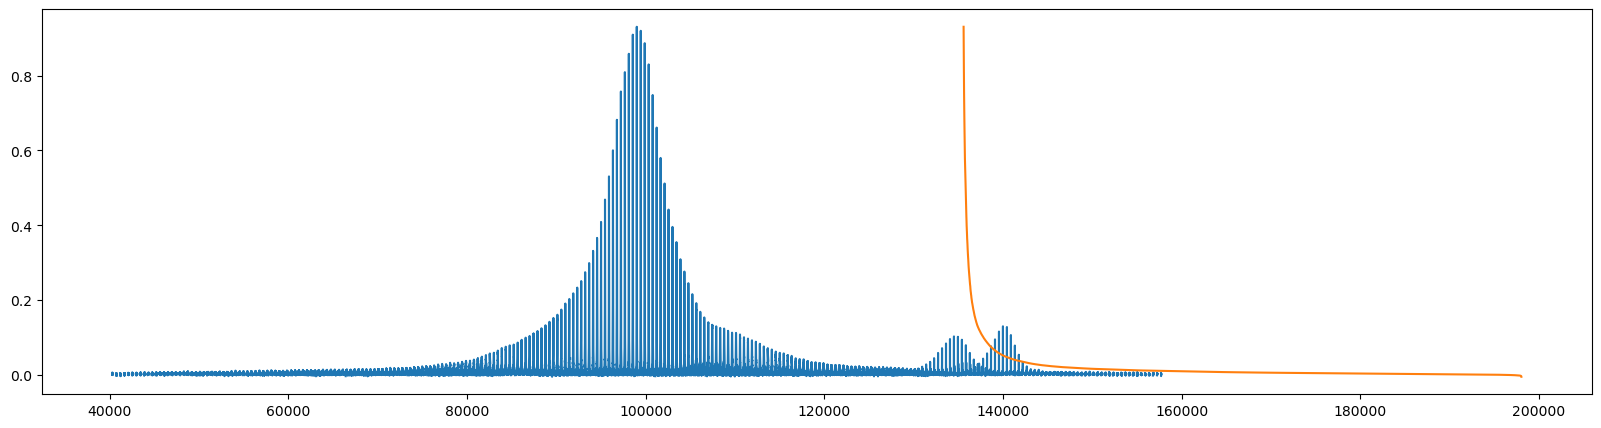

In [16]:
# with masked values
plt.plot(flattened_g)
plt.plot(flattened_g[sorted_pix_g])

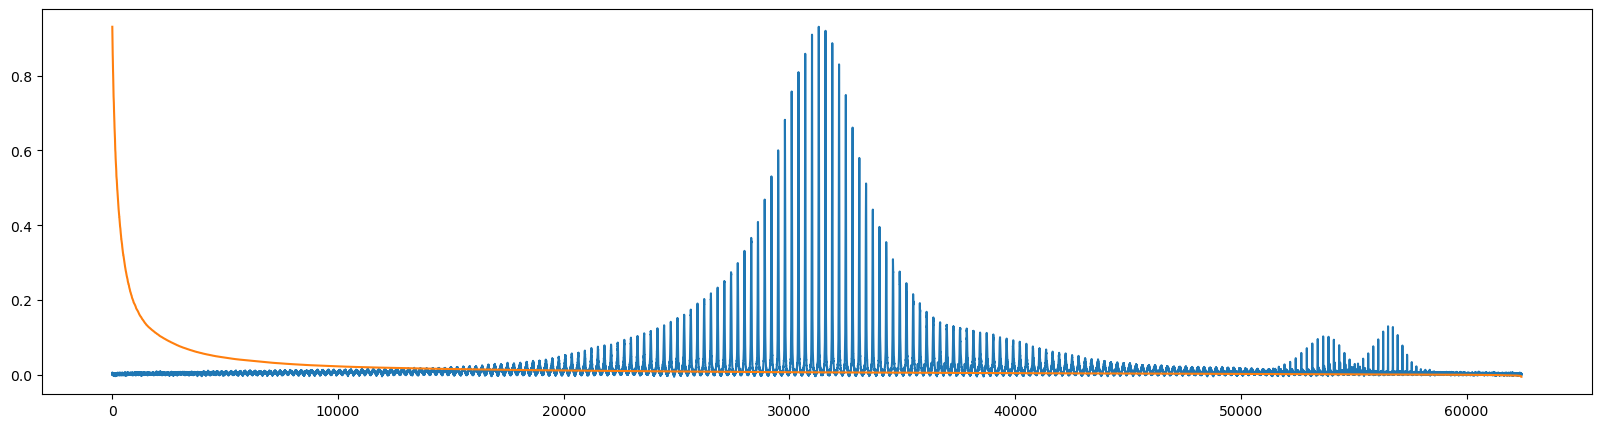

In [17]:
# without masked values
plt.plot(unmasked_flattened_g)
plt.plot(unmaskedintlistg)

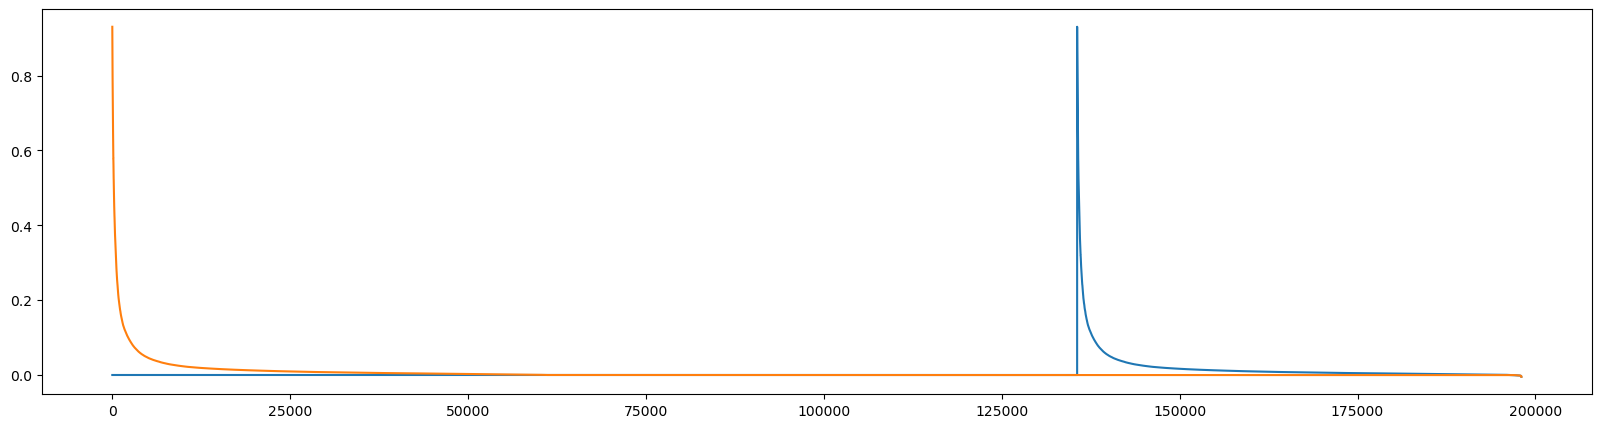

In [18]:
# filled masked values
plt.plot(filledflattened_g)
plt.plot(filledintlistg)

(222, 222)


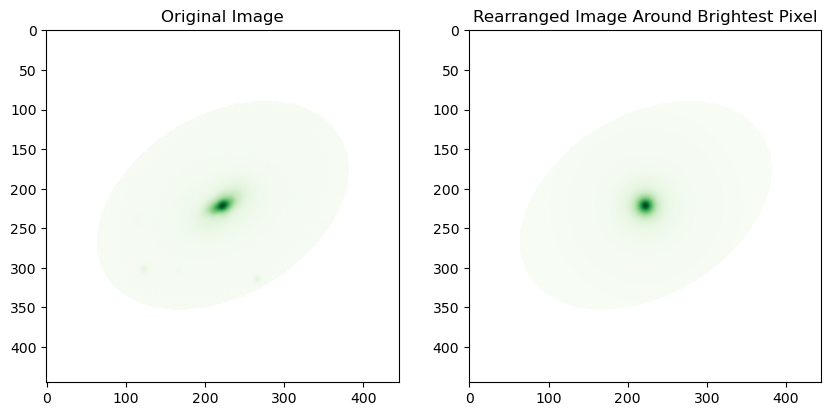

In [19]:
# find the indices of the brightest pixel in the original image
brightest_pixel_index_g = np.unravel_index(np.argmax(mmg_image, axis=None), mmg_image.shape)
print(brightest_pixel_index_g)

# calculate squared distances from the center (brightest pixel)
squared_distances_centeredg = (xg - brightest_pixel_index_g[1])**2 + (yg - brightest_pixel_index_g[0])**2

# sort the pixels based on squared distances from the center
sorted_distances_centeredg = np.argsort(squared_distances_centeredg.flatten())

# create a circular arrangement around the brightest pixel
arranged_imageg = np.zeros_like(mmg_image)
arranged_imageg.flat[sorted_distances_centeredg] = filledintlistg

arranged_imageg = ma.array(arranged_imageg, mask=mask_g)
#arranged_imageg = ma.array(arranged_imageg)

# plot the original and rearranged images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(mmg_image, cmap='Greens')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(arranged_imageg, cmap='Greens')
plt.title('Rearranged Image Around Brightest Pixel')

plt.show()

In [20]:
# messing around with the r band

# extract the image shape and coordinates for g, r, and z.
rowsr, colsr = mmr_image.shape
yr, xr = np.mgrid[0:rowsr, 0:colsr]
squared_distancer = xr**2 + yr**2

# flatten the images
flattened_r = np.ravel(mmr_image)
print("Pixel Intensity Array:", flattened_r)

# sort the indices by assosiated intensity pixel, greatest to lowest intensity
sorted_pix_r = np.argsort(flattened_r)[::-1]
print("Sorted Indices:", sorted_pix_r)

# make a list of intensity values, replacing masked values with 0
filledflattened_r = flattened_r.filled(0.0)[sorted_pix_r]
print("Intensity Values Masked with -100:", filledflattened_r)

# sort the indices replaced with zeros masked intensity, greatest to lowest
sorted_filled_pix_r = np.argsort(filledflattened_r)[::-1]
print("Sorted Indices Values with -100s:", sorted_filled_pix_r)

# sort the intensities of the replaced masked values
filledintlistr = filledflattened_r[sorted_filled_pix_r]
print("Sorted Filled Masked Intensities:", filledintlistr)

Pixel Intensity Array: [-- -- -- ... -- -- --]
Sorted Indices: [198024  55209  55225 ... 151428  94699  90690]
Intensity Values Masked with -100: [ 0.          0.          0.         ... -0.00914939 -0.01034471
 -0.01259323]
Sorted Indices Values with -100s: [135592 135593 135594 ... 198022 198023 198024]
Sorted Filled Masked Intensities: [ 1.6855426   1.681268    1.6515425  ... -0.00914939 -0.01034471
 -0.01259323]


(222, 223)


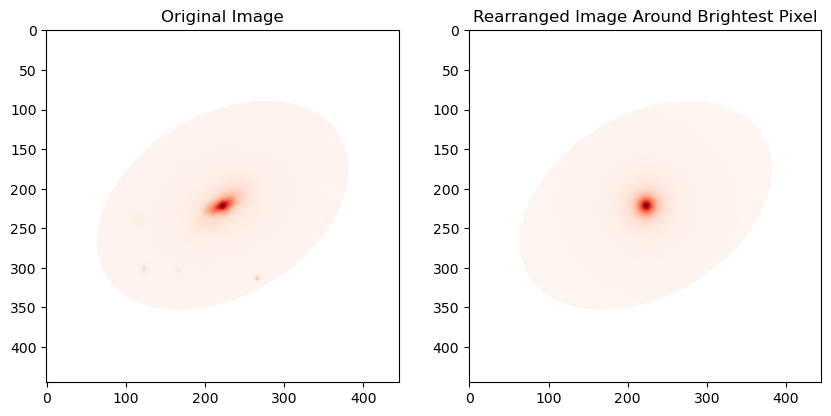

In [21]:
# find the indices of the brightest pixel in the original image
brightest_pixel_index_r = np.unravel_index(np.argmax(mmr_image, axis=None), mmr_image.shape)
print(brightest_pixel_index_r)

# calculate squared distances from the center (brightest pixel)
squared_distances_centeredr = (xr - brightest_pixel_index_r[1])**2 + (yr - brightest_pixel_index_r[0])**2

# sort the pixels based on squared distances from the center
sorted_distances_centeredr = np.argsort(squared_distances_centeredr.flatten())

# create a circular arrangement around the brightest pixel
arranged_imager = np.zeros_like(mmr_image)
arranged_imager.flat[sorted_distances_centeredr] = filledintlistr

arranged_imager = ma.array(arranged_imager, mask=mask_r)

# plot the original and rearranged images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(mmr_image, cmap='Reds')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(arranged_imager, cmap='Reds')
plt.title('Rearranged Image Around Brightest Pixel')

plt.show()

In [22]:
# messing around with the z band

# extract the image shape and coordinates for z
rowsz, colsz = mmz_image.shape
yz, xz = np.mgrid[0:rowsz, 0:colsz]
squared_distancez = xz**2 + yz**2

# flatten the images
flattened_z = np.ravel(mmz_image)
print("Pixel Intensity Array:", flattened_z)

# sort the indices by assosiated intensity pixel, greatest to lowest intensity
sorted_pix_z = np.argsort(flattened_z)[::-1]
print("Sorted Indices:", sorted_pix_z)

# make a list of intensity values, replacing masked values with 0
filledflattened_z = flattened_z.filled(0.0)[sorted_pix_z]
print("Intensity Values Masked with 0:", filledflattened_z)

# sort the indices replaced with zeros masked intensity, greatest to lowest
sorted_filled_pix_z = np.argsort(filledflattened_z)[::-1]
print("Sorted Indices Values with 0:", sorted_filled_pix_z)

# sort the intensities of the replaced masked values
filledintlistz = filledflattened_z[sorted_filled_pix_z]
print("Sorted Filled Masked Intensities:", filledintlistz)

Pixel Intensity Array: [-- -- -- ... -- -- --]
Sorted Indices: [198024  55209  55225 ...  52261  92455  87553]
Intensity Values Masked with 0: [ 0.          0.          0.         ... -0.0620943  -0.0641834
 -0.06742264]
Sorted Indices Values with 0: [135592 135593 135594 ... 198022 198023 198024]
Sorted Filled Masked Intensities: [ 2.3043232   2.247972    2.2453456  ... -0.0620943  -0.0641834
 -0.06742264]


(222, 223)


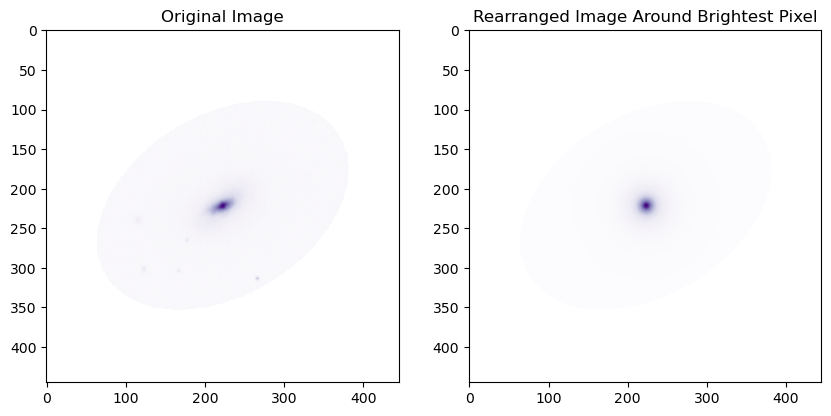

In [23]:
# find the indices of the brightest pixel in the original image
brightest_pixel_index_z = np.unravel_index(np.argmax(mmz_image, axis=None), mmz_image.shape)
print(brightest_pixel_index_z)

# calculate squared distances from the center (brightest pixel)
squared_distances_centeredz = (xz - brightest_pixel_index_z[1])**2 + (yz - brightest_pixel_index_z[0])**2

# sort the pixels based on squared distances from the center
sorted_distances_centeredz = np.argsort(squared_distances_centeredz.flatten())

# create a circular arrangement around the brightest pixel
arranged_imagez = np.zeros_like(mmz_image)
arranged_imagez.flat[sorted_distances_centeredz] = filledintlistz

arranged_imagez = ma.array(arranged_imagez, mask=mask_z)

# plot the original and rearranged images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(mmz_image, cmap='Purples')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(arranged_imagez, cmap='Purples')
plt.title('Rearranged Image Around Brightest Pixel')

plt.show()

Calculating Multiplicity Parameter:

$\Psi_{actual} = \sum_{i=1}^{N} \sum_{j=1,\, j \neq i}^{N} \dfrac{X_i \, X_j}{r_{ij}}$,
where the summation of the pixel fluxes Xi and Xj runs over all
N pixels in the segmentation map and rij is the distance (in pixels) between pixels i and j

$\Psi_{actual}$ is normalized by that which
would be achieved with the most compact possible rearrangement
of the flux pixels, i.e., the configuration that would require the
most ‘‘work’’ to pull apart. We rearrange the physical positions of
the N pixels of the segmentation map in a circular configuration
with the brightest pixel in the center and with pixel flux decreasing
outward with radius. Calling the distance between pixels i and j in
this rearranged map r'ij.

$\Psi_{compact} = \sum_{i=1}^{N} \sum_{j=1,\, j \neq i}^{N} \dfrac{X_i \, X_j}{r'_{ij}}$,

$\Psi = 100 \cdot \log(\dfrac{\Psi_{actual}}{\Psi_{compact}})$

In [24]:
print(f"Shape of image_data: {image_data.shape}")
print(f"Shape of mg_image: {mg_image.shape}")
print(f"Shape of mimage_data: {mimage_data.shape}")
print(type(mg_image))

Shape of image_data: (445, 445, 3)
Shape of mg_image: (445, 445)
Shape of mimage_data: (445, 445, 3)
<class 'numpy.ma.core.MaskedArray'>


In [ ]:
# get the pixel coordinates for non-masked pixels
y, x = np.where(~mmg_image.mask)

# rij_matrix where each element represents the distance between the corresponding pixel pairs
# distance = sqrt{ (x_2 - x_1)^2 + (y_2 - y_1)^2
rij_matrix = np.sqrt((x[:, np.newaxis] - x)**2 + (y[:, np.newaxis] - y)**2)
flux_matrix = mmg_image[y, x]

#print(rij_matrix)
#print(flux_matrix)

# apply the mask and sum the potential energy
actual_potential_energyg = 0.5*(np.sum(flux_matrix[np.newaxis, :] * flux_matrix[:, np.newaxis] / rij_matrix))

print("Actual Potential Energy G:", actual_potential_energyg)

# get the pixel coordinates for non-masked pixels
y, x = np.where(~arranged_imageg.mask)

# rij_matrix where each element represents the distance between the corresponding pixel pairs
# distance = sqrt{ (x_2 - x_1)^2 + (y_2 - y_1)^2
rij_matrix = np.sqrt((x[:, np.newaxis] - x)**2 + (y[:, np.newaxis] - y)**2)
flux_matrix = arranged_imageg[y, x]

#print(rij_matrix)
#print(flux_matrix)

# apply the mask and sum the potential energy
compact_potential_energyg = 0.5*(np.sum(flux_matrix[np.newaxis, :] * flux_matrix[:, np.newaxis] / rij_matrix))

print("Compact Potential Energy G:", compact_potential_energyg)

In [ ]:
# get the pixel coordinates for non-masked pixels
y, x = np.where(~mmr_image.mask)

# rij_matrix where each element represents the distance between the corresponding pixel pairs
# distance = sqrt{ (x_2 - x_1)^2 + (y_2 - y_1)^2
rij_matrix = np.sqrt((x[:, np.newaxis] - x)**2 + (y[:, np.newaxis] - y)**2)
flux_matrix = mmr_image[y, x]

# apply the mask and sum the potential energy
actual_potential_energyr = 0.5*(np.sum(flux_matrix[np.newaxis, :] * flux_matrix[:, np.newaxis] / rij_matrix))

print("Actual Potential Energy R:", actual_potential_energyr)

# get the pixel coordinates for non-masked pixels
y, x = np.where(~arranged_imager.mask)

# rij_matrix where each element represents the distance between the corresponding pixel pairs
# distance = sqrt{ (x_2 - x_1)^2 + (y_2 - y_1)^2
rij_matrix = np.sqrt((x[:, np.newaxis] - x)**2 + (y[:, np.newaxis] - y)**2)
flux_matrix = arranged_imager[y, x]

# apply the mask and sum the potential energy
compact_potential_energyr = 0.5*(np.sum(flux_matrix[np.newaxis, :] * flux_matrix[:, np.newaxis] / rij_matrix))

print("Compact Potential Energy R:", compact_potential_energyr)

In [ ]:
# get the pixel coordinates for non-masked pixels
y, x = np.where(~mmz_image.mask)

# rij_matrix where each element represents the distance between the corresponding pixel pairs
# distance = sqrt{ (x_2 - x_1)^2 + (y_2 - y_1)^2
rij_matrix = np.sqrt((x[:, np.newaxis] - x)**2 + (y[:, np.newaxis] - y)**2)
flux_matrix = mmz_image[y, x]

# apply the mask and sum the potential energy
actual_potential_energyz = 0.5*(np.sum(flux_matrix[np.newaxis, :] * flux_matrix[:, np.newaxis] / rij_matrix))

print("Actual Potential Energy Z:", actual_potential_energyz)

# get the pixel coordinates for non-masked pixels
y, x = np.where(~arranged_imagez.mask)

# rij_matrix where each element represents the distance between the corresponding pixel pairs
# distance = sqrt{ (x_2 - x_1)^2 + (y_2 - y_1)^2
rij_matrix = np.sqrt((x[:, np.newaxis] - x)**2 + (y[:, np.newaxis] - y)**2)
flux_matrix = arranged_imagez[y, x]

# apply the mask and sum the potential energy
compact_potential_energyz = 0.5*(np.sum(flux_matrix[np.newaxis, :] * flux_matrix[:, np.newaxis] / rij_matrix))

print("Compact Potential Energy Z:", compact_potential_energyz)

In [ ]:
# calcualting the multiplicity parameter
multiplicityg = 100*(np.log10(compact_potential_energyg / actual_potential_energyg))
multiplicityr = 100*(np.log10(compact_potential_energyr / actual_potential_energyr))
multiplicityz = 100*(np.log10(compact_potential_energyz / actual_potential_energyz))

In [ ]:
print("Multiplicity Parameter:", multiplicityg)
print("Multiplicity Parameter:", multiplicityr)
print("Multiplicity Parameter:", multiplicityz)